# **Joshua Cohn Capstone Part 1 - mini-DDSM Data Management**
 **Mammography Cancer Classification**<br>
 **BrainStation Data Science Bootcamp**<br>
 **Joshua Cohn**<br>
 **Email: Joshcohn3@gmail.com**<br>
 **Due Date: December 12, 2022**
--- 

Breast Cancer is the second most leading cause of cancer related death in women with a case fatality rate of 2.5%.  The United States Preventive Services Task Force (USPSTF) recommends women who are between 50-74 years old to get a mammography screening for breast cancer every 2 years.  The mammography screening consists of a specialised X-ray imaging of the breast tissue and a radiologist will afterwards look for lumps or high density tissue in the images.

If signs of cancer are observed in the mammogram images, the patient will be asked to follow up with an invasive biopsy of the breast tissue for a more accurate diagnosis.  The goal of this project is to use state of the art computer imaging models to analyse mammogram images and create a model that can aid radiologists in diagnosing cancer in images prior to biopsy.

Two datasets, the mini-Digital Database of Screening Mammography (mini-DDSM) and Chinese Mammography Data (CMMD) were used in this project.  The mini-DDSM consists of 7,808 mammogram images from 1,952 patients and were stored in .png and .jpeg files.  The CMMD dataset consists of 5,202 mammogram images from 1,775 patients and were stored as dicom medical files.


---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from PIL import Image as im
from IPython.display import Image
import os
from tensorflow.keras.utils import load_img
%matplotlib inline

---

## **Importing Mini-DDSM Data**

https://ardisdataset.github.io/MiniDDSM/

In [3]:
mini_ddsm_df=pd.read_csv(r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Data-MoreThanTwoMasks\Data-MoreThanTwoMasks.csv')
mini_ddsm_df.head()

,fullPath,fileName,View,Side,Status,Age,Density,Tumour_Contour,Tumour_Contour2,Tumour_Contour3,Tumour_Contour4,Tumour_Contour5,Tumour_Contour6
0,Benign\0029\C_0029_1.LEFT_CC.png,C_0029_1.LEFT_CC.png,CC,LEFT,Benign,66.0,3,Benign\0029\C_0029_1.LEFT_CC_Mask.png,-,NaN,NaN,NaN,NaN
1,Benign\0029\C_0029_1.LEFT_MLO.png,C_0029_1.LEFT_MLO.png,MLO,LEFT,Benign,66.0,3,Benign\0029\C_0029_1.LEFT_MLO_Mask.png,-,NaN,NaN,NaN,NaN
2,Benign\0029\C_0029_1.RIGHT_CC.png,C_0029_1.RIGHT_CC.png,CC,RIGHT,Benign,66.0,3,-,-,NaN,NaN,NaN,NaN
3,Benign\0029\C_0029_1.RIGHT_MLO.png,C_0029_1.RIGHT_MLO.png,MLO,RIGHT,Benign,66.0,3,-,-,NaN,NaN,NaN,NaN
4,Benign\0033\C_0033_1.LEFT_CC.png,C_0033_1.LEFT_CC.png,CC,LEFT,Benign,60.0,3,-,-,NaN,NaN,NaN,NaN


In [4]:
mini_ddsm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7808 entries, 0 to 7807
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fullPath         7808 non-null   object 
 1   fileName         7808 non-null   object 
 2   View             7808 non-null   object 
 3   Side             7808 non-null   object 
 4   Status           7808 non-null   object 
 5   Age              7796 non-null   float64
 6   Density          7808 non-null   int64  
 7   Tumour_Contour   7808 non-null   object 
 8   Tumour_Contour2  7808 non-null   object 
 9   Tumour_Contour3  50 non-null     object 
 10  Tumour_Contour4  8 non-null      object 
 11  Tumour_Contour5  2 non-null      object 
 12  Tumour_Contour6  2 non-null      object 
dtypes: float64(1), int64(1), object(11)
memory usage: 793.1+ KB


**Filling 12 Missing Age Values with Median**

In [5]:
mini_ddsm_df.Age.fillna(mini_ddsm_df.Age.median(),inplace=True)
mini_ddsm_df.isnull().sum()

fullPath              0
fileName              0
View                  0
Side                  0
Status                0
Age                   0
Density               0
Tumour_Contour        0
Tumour_Contour2       0
Tumour_Contour3    7758
Tumour_Contour4    7800
Tumour_Contour5    7806
Tumour_Contour6    7806
dtype: int64

### **Paths to Images**

In [5]:
#Accessing Image Paths
os_walk=os.walk(r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\MINI-DDSM-Complete-PNG-16')

#lists to store paths of images
benign_paths=[]
malignant_paths=[]
normal_paths=[]

# list of file names & directory
benign_file_names=[]
malignant_file_names=[]
normal_file_names=[]

for dirname, _, filenames in os_walk:
    for filename in filenames:
        path=os.path.join(dirname, filename)
        if (dirname.__contains__("Benign")==True) & (filename.__contains__("Mask")==False)& (filename.__contains__("MASK2")==False) & (filename.__contains__(".png")==True):
            benign_paths.append(path)
            benign_file_names.append(filename)
        elif (dirname.__contains__("Cancer")==True) & (filename.__contains__("Mask")==False)& (filename.__contains__("MASK2")==False) & (filename.__contains__(".png")==True):
            malignant_paths.append(path)
            malignant_file_names.append(filename)
        elif (dirname.__contains__("Normal")==True) & (filename.__contains__("Mask")==False)& (filename.__contains__("MASK2")==False) & (filename.__contains__(".png")==True):
            normal_paths.append(path)
            normal_file_names.append(filename)
            
print("Mammography Image Summary: Benign %s, Cancer %s, Normal %s, Total %s" % (len(benign_paths),len(malignant_paths),len(normal_paths),len(benign_paths)+len(malignant_paths)+len(normal_paths)))

Mammography Image Summary: Benign 2684, Cancer 2716, Normal 2408, Total 7808


---

### **Creating X & y**

In [10]:
# turning file paths to images into a dataframe
path_df = pd.DataFrame({'Image_Path':benign_paths+malignant_paths+normal_paths,'File_Names':benign_file_names+malignant_file_names+normal_file_names})

# defining X & y
X = pd.concat([path_df,mini_ddsm_df[['View','Side','Status','Age','Density']]],axis=1)

# Declaring Status == 'Cancer' as target variable and dropping it from the X dataframe
y = pd.Series(np.where(X['Status']=='Cancer',1,0),name='Malignancy')
X.drop('Status',axis=1,inplace=True)

**Feature DataFrame**

In [11]:
X.head()

,Image_Path,File_Names,View,Side,Age,Density
0,C:\Users\joshc\Documents\BrainStation\Capstone...,C_0029_1.LEFT_CC.png,CC,LEFT,66.0,3
1,C:\Users\joshc\Documents\BrainStation\Capstone...,C_0029_1.LEFT_MLO.png,MLO,LEFT,66.0,3
2,C:\Users\joshc\Documents\BrainStation\Capstone...,C_0029_1.RIGHT_CC.png,CC,RIGHT,66.0,3
3,C:\Users\joshc\Documents\BrainStation\Capstone...,C_0029_1.RIGHT_MLO.png,MLO,RIGHT,66.0,3
4,C:\Users\joshc\Documents\BrainStation\Capstone...,C_0033_1.LEFT_CC.png,CC,LEFT,60.0,3


In [12]:
print("Shape of X Data is %s rows and %s columns" % (X.shape[0],X.shape[1]))

Shape of X Data is 7808 rows and 6 columns


**Target Variable**

In [14]:
# y is classification of whether or not the image is from a patient with cancer positive
# 1 = Cancer, 0 = Benign or Normal
print("Target Variable Data y")
y

Target Variable Data y


0       0
1       0
2       0
3       0
4       0
       ..
7803    0
7804    0
7805    0
7806    0
7807    0
Name: Malignancy, Length: 7808, dtype: int32

---

## **Image EDA**

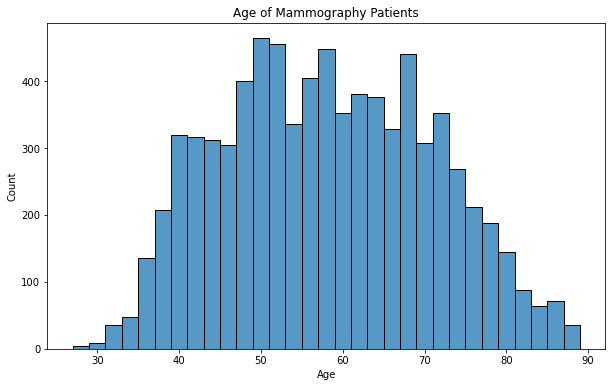

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(mini_ddsm_df.Age,bins=int((mini_ddsm_df.Age.max()-mini_ddsm_df.Age.min())/2))
plt.title("Age of Mammography Patients")
plt.show()


In [29]:
import math

binned_age_df=mini_ddsm_df.Age
binned_age_df=[math.floor(x/5)*5+2.5 for x in binned_age_df.values.tolist()]
binned_age_df=pd.DataFrame({"Age":binned_age_df,'Diagnosis':})

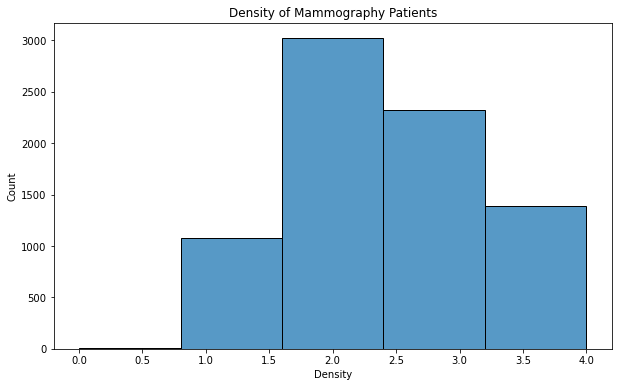

In [109]:
plt.figure(figsize=(10,6))
sns.histplot(mini_ddsm_labels.Density,bins=5)
plt.title("Density of Mammography Patients")
plt.show()

---

### **Importing Images**

In [9]:
#For loop to gather the pixel information of the mammography images
image_dimension_list=[]
for path in benign_paths+malignant_paths+normal_paths: # iterates through file paths for all images
    img=np.asarray(load_img(path))[:,:,0]
    image_dimension_list.append((img.shape[0],img.shape[1]))


In [10]:
len(image_dimension_list)

7808

In [15]:
image_width_pixels=[]
image_length_pixels=[]

for image_shape in image_dimension_list:
    image_width_pixels.append(image_shape[0])
    image_length_pixels.append(image_shape[1])

**Image Width in Pixels**

In [16]:
pd.DataFrame({'image_width_pixels':image_width_pixels}).describe()

,image_width_pixels
count,7808.000000
mean,2676.350666
std,332.264894
min,1088.000000
25%,2368.000000
50%,2671.000000
75%,2876.000000
max,3481.000000


### Image Size

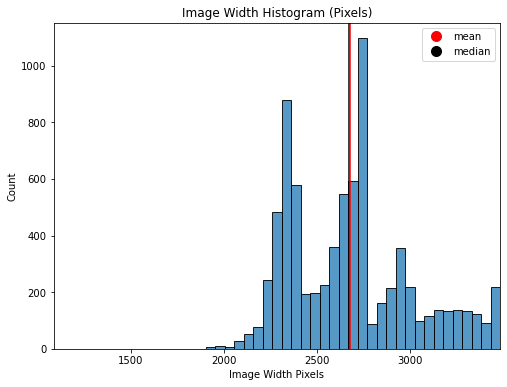

In [37]:
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size
sns.histplot(image_width_pixels)
plt.xlim([min(image_width_pixels),max(image_width_pixels)])
plt.xlabel('Image Width Pixels')

red_dot=mlines.Line2D([],[],color='red',marker='o',linestyle='None',markersize=10,label='mean')
black_dot=mlines.Line2D([],[],color='black',marker='o',linestyle='None',markersize=10,label='median')
plt.legend(handles=[red_dot,black_dot])

plt.axvline(pd.DataFrame({'image_width_pixels':image_width_pixels}).median().values.tolist()[0],color='black')
plt.axvline(pd.DataFrame({'image_width_pixels':image_width_pixels}).mean().values.tolist()[0],color='red')
plt.title('Image Width Histogram (Pixels)')
plt.savefig('Mammography_Image_Width_Histogram.png')
plt.show()

In [21]:
pd.DataFrame({'image_length_pixels':image_length_pixels}).describe()

,image_length_pixels
count,7808.000000
mean,1536.334273
std,312.499608
min,495.000000
25%,1321.000000
50%,1477.000000
75%,1736.000000
max,2746.000000


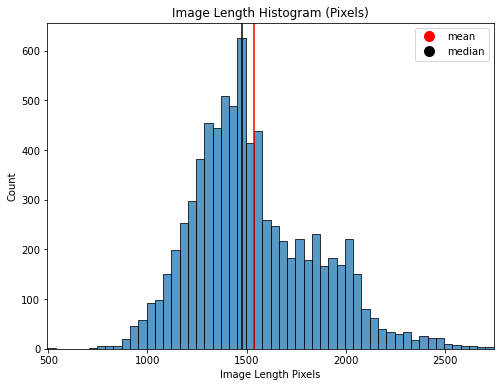

In [40]:
sns.histplot(image_length_pixels)
plt.xlim([min(image_length_pixels),max(image_length_pixels)])
plt.title('Image Length Histogram (Pixels)')
plt.xlabel('Image Length Pixels')
plt.axvline(pd.DataFrame({'image_length_pixels':image_length_pixels}).median().values.tolist()[0],color='black')
plt.axvline(pd.DataFrame({'image_length_pixels':image_length_pixels}).mean().values.tolist()[0],color='red')

red_dot=mlines.Line2D([],[],color='red',marker='o',linestyle='None',markersize=10,label='mean')
black_dot=mlines.Line2D([],[],color='black',marker='o',linestyle='None',markersize=10,label='median')
plt.legend(handles=[red_dot,black_dot])


plt.savefig('Mammography_Image_Length_Histogram.png')
plt.show()

The Black & Red lines on the pixel length histograms represents the median & mean respectively of the dimension in pixel size.  Since the mean & median for both length and width were similar, using the median seemed to be the most convenient measurement as the size for the normalization of all images moving forward.

For image convolutional networks to operate all images must be normalized to the same size.  Any images below or above the median will be scaled up or down accordingly using bilinear interpolation in Keras.

Median Image Width (Pixels): `2671`

Median Image Length (Pixels): `1477`

---

---

## **Moving Images to Directories**

In [17]:
from sklearn.model_selection import train_test_split

random_state=1 # DO NOT CHANGE THIS

# Train_test split where test_size=20%
X_train, X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=random_state,stratify=y)

# Train_Validation split where test_size=25%
X_train, X_validation,y_train,y_validation=train_test_split(X_train,y_train,test_size=.25,random_state=random_state,stratify=y_train)

In [18]:
X_test.columns.tolist()

['Image_Path', 'File_Names', 'View', 'Side', 'Age', 'Density']

In [ ]:
# Defining the path to all the directories

# test directories path
test_benign_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Test\Benign'
test_cancer_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Test\Cancer'

# train directories path
train_benign_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Train\Benign'
train_cancer_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Train\Cancer'

# validation directories path
validation_benign_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Validation\Benign'
validation_cancer_dir=r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Image_Directory\Validation\Cancer'

**Train Image Movement**

In [ ]:
for i in range(len(X_train)):
    
    original_path=X_train['Image_Path'].iloc[i]
    
    if y_train.iloc[i]==0:
        final_path=os.path.join(train_benign_dir,X_train['File_Names'].iloc[i])
    
    elif y_train.iloc[i]==1:
        final_path=os.path.join(train_cancer_dir,X_train['File_Names'].iloc[i])
    
    os.rename(original_path,final_path)

**Test Image Movement**

In [ ]:
for i in range(len(X_test)):
    
    original_path=X_test['Image_Path'].iloc[i]
    
    if y_test.iloc[i]==0:
        final_path=os.path.join(test_benign_dir,X_test['File_Names'].iloc[i])
    
    elif y_test.iloc[i]==1:
        final_path=os.path.join(test_cancer_dir,X_test['File_Names'].iloc[i])
    
    os.rename(original_path,final_path)

**Validation Image Movement**

In [ ]:
for i in range(len(X_validation)):
    
    original_path=X_validation['Image_Path'].iloc[i]
    
    if y_validation.iloc[i]==0:
        final_path=os.path.join(validation_benign_dir,X_validation['File_Names'].iloc[i])
    
    elif y_validation.iloc[i]==1:
        final_path=os.path.join(validation_cancer_dir,X_validation['File_Names'].iloc[i])
    
    os.rename(original_path,final_path)

## **Age & Density for Classification**

In [29]:
mini_ddsm_df=pd.read_csv(r'C:\Users\joshc\Documents\BrainStation\Capstone Project\Mammography Data\The Complete Mini-DDSM\Data-MoreThanTwoMasks\Data-MoreThanTwoMasks.csv')

#imputing the 12 missing ages with the median age
mini_ddsm_df.Age.fillna(mini_ddsm_df.Age.median(),inplace=True)
mini_ddsm_df.isnull().sum()

#removing all normal status images due to white blotches on images
mini_ddsm_removed_normals=mini_ddsm_df[:5400].copy()
mini_ddsm_removed_normals.head()

,fullPath,fileName,View,Side,Status,Age,Density,Tumour_Contour,Tumour_Contour2,Tumour_Contour3,Tumour_Contour4,Tumour_Contour5,Tumour_Contour6
0,Benign\0029\C_0029_1.LEFT_CC.png,C_0029_1.LEFT_CC.png,CC,LEFT,Benign,66.0,3,Benign\0029\C_0029_1.LEFT_CC_Mask.png,-,NaN,NaN,NaN,NaN
1,Benign\0029\C_0029_1.LEFT_MLO.png,C_0029_1.LEFT_MLO.png,MLO,LEFT,Benign,66.0,3,Benign\0029\C_0029_1.LEFT_MLO_Mask.png,-,NaN,NaN,NaN,NaN
2,Benign\0029\C_0029_1.RIGHT_CC.png,C_0029_1.RIGHT_CC.png,CC,RIGHT,Benign,66.0,3,-,-,NaN,NaN,NaN,NaN
3,Benign\0029\C_0029_1.RIGHT_MLO.png,C_0029_1.RIGHT_MLO.png,MLO,RIGHT,Benign,66.0,3,-,-,NaN,NaN,NaN,NaN
4,Benign\0033\C_0033_1.LEFT_CC.png,C_0033_1.LEFT_CC.png,CC,LEFT,Benign,60.0,3,-,-,NaN,NaN,NaN,NaN


In [30]:
# paths to images
mini_ddsm_removed_normals['Path']=benign_paths+malignant_paths

# redefining cancer as string to integer
mini_ddsm_removed_normals['Classification']=np.where(mini_ddsm_removed_normals.Status=='Cancer',1,0)

mini_ddsm_removed_normals[['Path','Age','Density','Status','fileName','Classification']].head()

,Path,Age,Density,Status,fileName,Classification
0,C:\Users\joshc\Documents\BrainStation\Capstone...,66.0,3,Benign,C_0029_1.LEFT_CC.png,0
1,C:\Users\joshc\Documents\BrainStation\Capstone...,66.0,3,Benign,C_0029_1.LEFT_MLO.png,0
2,C:\Users\joshc\Documents\BrainStation\Capstone...,66.0,3,Benign,C_0029_1.RIGHT_CC.png,0
3,C:\Users\joshc\Documents\BrainStation\Capstone...,66.0,3,Benign,C_0029_1.RIGHT_MLO.png,0
4,C:\Users\joshc\Documents\BrainStation\Capstone...,60.0,3,Benign,C_0033_1.LEFT_CC.png,0


In [92]:
print("Nulls in mini-DDSM DataFrame")
mini_ddsm_removed_normals.isnull().sum()

Nulls in mini-DDSM DataFrame


fullPath              0
fileName              0
View                  0
Side                  0
Status                0
Age                   0
Density               0
Tumour_Contour        0
Tumour_Contour2       0
Tumour_Contour3    5350
Tumour_Contour4    5392
Tumour_Contour5    5398
Tumour_Contour6    5398
Path                  0
Classification        0
dtype: int64

In [87]:
def PlotBoundaries(model, X, Y, figsize=(10, 8)):
    '''
    Helper function that plots the decision boundaries of a model and data (X,Y)
    code modified from: https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
    '''

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=figsize)
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Plot
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=20, edgecolor='k')
    plt.xlabel('age')
    plt.ylabel('density')
    plt.title('Plot Boundaries of Age & Density to Classify Cancer')
    plt.show()

In [33]:
from sklearn.model_selection import train_test_split

X=mini_ddsm_removed_normals[['Age','Density']]
y=mini_ddsm_removed_normals['Classification']

#test train split for logistic regression to determine impact of age & density on classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
# Age & Density DataFrame
X

,Age,Density
0,66.0,3
1,66.0,3
2,66.0,3
3,66.0,3
4,60.0,3
...,...,...
5395,64.0,3
5396,65.0,3
5397,65.0,3
5398,65.0,3


In [91]:
#Proportion of Cancer in Dataset
y.value_counts(normalize=True)

1    0.502963
0    0.497037
Name: Classification, dtype: float64

In [90]:
from sklearn.linear_model import LogisticRegression

#instantiate model
log_model=LogisticRegression()

#fit training data
log_model.fit(X_train,y_train)

print(f'Training Accuracy: {round(neigh.score(X_train,y_train)*100,4)}%')
print(f'Test Accuracy: {round(neigh.score(X_test,y_test)*100,4)}%')

Training Accuracy: 65.1741%
Test Accuracy: 65.2076%


C:\Users\joshc\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


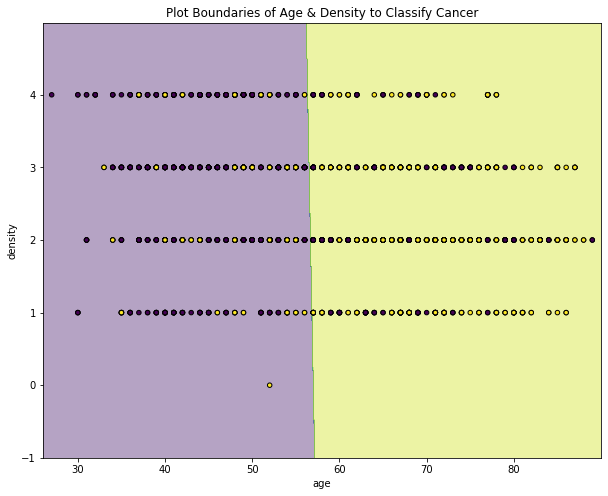

In [88]:
#Plotting Age & Density vs Cancer Classification
PlotBoundaries(log_model,np.asarray(X_test),np.asarray(y_test))

The PlotBoundaries function using a Logistic Regression Classifier shows that age is a much more important feature for classification than density is.  We will want to use age as a feature alongside our convolutional neural network model moving forward.